In [1]:
import os
os.chdir('C:/Users/erihoward/Documents/GitHub/Heart_Disease_Classification/')

In [6]:
import pandas as pd
from config import X_TEST_PATH, Y_TEST_PATH, INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, MODEL_VERSION, MODEL_NAME, THRESHOLD
from src.models.FFNN import FFNN
from src.data.Dataset import Dataset
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Load and instantiate the appropriate model (based on config)
input_size = INPUT_SIZE
hidden_size = HIDDEN_SIZE
output_size = OUTPUT_SIZE
model = FFNN(input_size, hidden_size, output_size)
model.load_state_dict(torch.load(MODEL_VERSION))
model.eval()

FFNN(
  (input): Linear(in_features=22, out_features=100, bias=True)
  (hidden): Linear(in_features=100, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (last): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [8]:
# load the test features and labels
test_features_path = X_TEST_PATH
test_features = Dataset(test_features_path, 'inference')
test_labels_path = Y_TEST_PATH
test_labels = pd.read_csv(test_labels_path).values

In [9]:
# Clean and transform the test features based on Dataset Module
test_features.basic_clean()
test_transformed = test_features.transform_data()['X_inference']

# Convert the test features appropriately for use with PyTorch
inference_data = torch.tensor(test_transformed.values, dtype=torch.float32)

# Convert labels to tensor for use with PyTorch
test_labels_pt = torch.tensor(test_labels, dtype=torch.float32)

# Generate inference using the model
with torch.no_grad():
    predictions = model(inference_data)

# Reshape the labels to match the model output
test_labels_reshaped = test_labels_pt.reshape(predictions.shape)

# Using torch built in capabilities, evaluate the model given predictions and true labels
criterion = torch.nn.BCELoss()
loss = criterion(predictions, test_labels_reshaped)

# This will print the Binary Cross Entropy Loss (less than 0.5 is good!)
print(round(loss.item(), 3))


1.15


In [10]:
# For visualization purposes, we can calculate the confusion matrix

# Calculate True Positives (TP)
tp = ((predictions >= THRESHOLD) & (test_labels_reshaped == 1)).sum().item()

# Calculate True Negatives (TN)
tn = ((predictions < THRESHOLD) & (test_labels_reshaped == 0)).sum().item()

# Calculate False Positives (FP)
fp = ((predictions >= THRESHOLD) & (test_labels_reshaped == 0)).sum().item()

# Calculate False Negatives (FN)
fn = ((predictions < THRESHOLD) & (test_labels_reshaped == 1)).sum().item()

# Print the values
print("True Positives (TP):", tp)
print("True Negatives (TN):", tn)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)

True Positives (TP): 83
True Negatives (TN): 84
False Positives (FP): 27
False Negatives (FN): 44


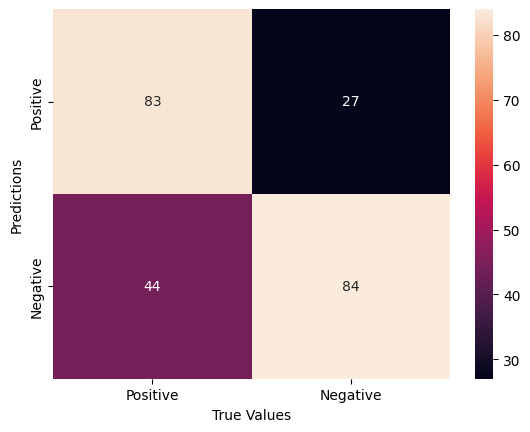

In [11]:
# Visualize and save the confusion matrix

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the confusion matrix using seaborn
sns.heatmap([[tp, fp], [fn, tn]], annot=True, fmt='d', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'], ax=ax)

# Set the labels for the x-axis and y-axis
ax.set_xlabel('True Values')
ax.set_ylabel('Predictions')

# Show the plot
plt.show()

# Save the plot to results folder
fig.savefig(f'results/confusion_matrix_{MODEL_NAME}.png')